<h2> Choropleth Maps by State </h2>
Also includes some boxplots for comparisons of error over time (year / yearmonth)

In [1]:
#01 - Imports
import pandas as pd
import numpy as np
import datetime as dt
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("results_test.csv", encoding="utf-8")
df

,key,start_date,lat,lon,xgboost_tmp2m_pred_zscore,tmp2m_daily_mean,tmp2m_daily_std,tmp2m_zscore,tmp2m,xgboost_tmp2m_pred,err,phys,phys_err
0,2019-10-01|27.25|261.75,2019-10-01,27.25,261.75,1.028229,22.870967,2.045002,-0.014837,22.840626,24.973697,2.133071,17.826860,-5.013765
1,2019-10-01|27.25|277.75,2019-10-01,27.25,277.75,0.602405,23.886820,1.095936,3.186881,27.379438,24.547017,2.832422,19.966705,-7.412733
2,2019-10-01|27.25|279.75,2019-10-01,27.25,279.75,0.285290,24.353932,0.992701,2.720873,27.054945,24.637140,2.417805,21.474310,-5.580635
3,2019-10-01|29.25|259.75,2019-10-01,29.25,259.75,0.677093,21.986072,2.040617,-0.325284,21.322292,23.367759,2.045467,14.625558,-6.696734
4,2019-10-01|29.25|261.75,2019-10-01,29.25,261.75,1.178884,21.320222,2.163752,-0.391424,20.473276,23.871034,3.397758,14.187637,-6.285639
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26393,2020-07-28|47.25|265.75,2020-07-28,47.25,265.75,-0.024450,18.610993,1.730824,0.599149,19.648014,18.568675,1.079339,8.760571,-10.887443
26394,2020-07-28|47.25|267.75,2020-07-28,47.25,267.75,0.352289,17.596814,1.729239,0.772011,18.931807,18.206006,0.725801,8.714696,-10.217111
26395,2020-07-28|47.25|269.75,2020-07-28,47.25,269.75,0.450236,17.672248,1.595401,0.765863,18.894106,18.390556,0.503550,8.962629,-9.931477
26396,2020-07-28|47.25|271.75,2020-07-28,47.25,271.75,0.269793,17.870772,1.474947,1.511164,20.099659,18.268703,1.830956,9.780845,-10.318814


In [8]:
df.lon.min()

237.75

In [58]:
#Consolidate data
df = pd.read_csv("results_test.csv", encoding="utf-8")
df['lon2'] = df['lon']-360
df['latlon'] = df['lat'].astype(str) + "|" + df['lon'].astype(str)
df['start_date'] = pd.to_datetime(df['start_date'])
df['month'] = pd.DatetimeIndex(df['start_date']).month
df['month2'] = df['month'].astype(str).str.zfill(2)
df['year'] = pd.DatetimeIndex(df['start_date']).year
df['yearmonth'] = df['year'].astype(str) + '-' + df['month2'].astype(str)
df['err'] = round(df['err'],3)
df['phys_err'] = round(df['phys_err'],3)

#Seasons
def season (x):
    if x in [12,1,2]:
        return 'winter'
    elif x in [3,4,5]:
        return 'spring'
    elif x in [6,7,8]:
        return 'summer'
    elif x in [9,10,11]:
        return 'fall'

#Locations
locations = pd.read_csv("locations.csv", encoding="utf-8")
locations.rename(columns={"Location": "latlon"}, inplace=True)
locations.sort_values(by=['latlon'], ascending=False)


#Map season and location and extremes
df['season'] = df['month'].apply(season)
df = pd.merge(df, locations, on='latlon')
df['heatwave'] = df['tmp2m'] >34
df['coldwave'] = df['tmp2m'] <-10

#Functions / Metrics
def mbe (x):
    return round(np.mean(x),3)

def mae (x):
    return round(np.mean(abs(x)), 3)

def sd (x):
    return round(np.std(x), 3)

df

,key,start_date,lat,lon,xgboost_tmp2m_pred_zscore,tmp2m_daily_mean,tmp2m_daily_std,tmp2m_zscore,tmp2m,xgboost_tmp2m_pred,...,month,month2,year,yearmonth,season,State,Sub-Region,Region,heatwave,coldwave
0,2019-10-01|27.25|261.75,2019-10-01,27.25,261.75,1.028229,22.870967,2.045002,-0.014837,22.840626,24.973697,...,10,10,2019,2019-10,fall,Texas,West South Central,South,False,False
1,2019-10-08|27.25|261.75,2019-10-08,27.25,261.75,1.093624,21.721882,1.985609,-1.286955,19.166492,23.893391,...,10,10,2019,2019-10,fall,Texas,West South Central,South,False,False
2,2019-10-15|27.25|261.75,2019-10-15,27.25,261.75,1.043933,20.675154,2.121438,-1.040800,18.467161,22.889792,...,10,10,2019,2019-10,fall,Texas,West South Central,South,False,False
3,2019-10-22|27.25|261.75,2019-10-22,27.25,261.75,0.892237,19.451975,2.304340,-1.896681,15.081376,21.507993,...,10,10,2019,2019-10,fall,Texas,West South Central,South,False,False
4,2019-10-29|27.25|261.75,2019-10-29,27.25,261.75,0.883454,18.518180,2.384524,-1.176233,15.713424,20.624798,...,10,10,2019,2019-10,fall,Texas,West South Central,South,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26393,2021-06-29|47.25|273.75,2021-06-29,47.25,273.75,-0.061508,15.384313,2.808936,0.734029,17.446154,15.211542,...,6,06,2021,2021-06,summer,Michigan,East North Central,Midwest,False,False
26394,2020-07-07|47.25|273.75,2020-07-07,47.25,273.75,-0.408582,16.091479,2.732136,-0.339037,15.165182,14.975177,...,7,07,2020,2020-07,summer,Michigan,East North Central,Midwest,False,False
26395,2020-07-14|47.25|273.75,2020-07-14,47.25,273.75,-0.268441,16.598514,2.503675,-0.350005,15.722215,15.926424,...,7,07,2020,2020-07,summer,Michigan,East North Central,Midwest,False,False
26396,2020-07-21|47.25|273.75,2020-07-21,47.25,273.75,-0.357121,16.739847,2.226671,0.118659,17.004061,15.944656,...,7,07,2020,2020-07,summer,Michigan,East North Central,Midwest,False,False


In [44]:
#CHARTDATA 1 - FORECASTS ON ANY PARTICULAR DAY
#Get a plottable subset
sd = '2019-10-01'
df_subset = df[df['start_date']==sd]
df_subset
chartdata1 = pd.pivot_table(data=df_subset, index='State', values=['tmp2m','xgboost_tmp2m_pred', 'phys'], aggfunc=np.average)

#Get shapefile into geopandas dataframe and merge in forecasts
gdf = gpd.read_file('./us_states/cb_2018_us_state_500k.shp')
gdf = gdf.drop(columns=['ALAND', 'AWATER'])
gdf = gdf.rename(columns={"NAME":"State"})
gdf = gdf.merge(chartdata1, on='State')
gdf


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,State,LSAD,geometry,phys,tmp2m,xgboost_tmp2m_pred
0,37,01027616,0400000US37,37,NC,North Carolina,00,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",5.981435,15.451729,15.685775
1,40,01102857,0400000US40,40,OK,Oklahoma,00,"POLYGON ((-103.00257 36.52659, -103.00219 36.6...",7.174746,13.548646,17.288833
2,51,01779803,0400000US51,51,VA,Virginia,00,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...",2.867885,13.286313,13.565082
3,54,01779805,0400000US54,54,WV,West Virginia,00,"POLYGON ((-82.64320 38.16909, -82.64300 38.169...",-0.569301,11.892217,12.320529
4,22,01629543,0400000US22,22,LA,Louisiana,00,"MULTIPOLYGON (((-88.86770 29.86155, -88.86566 ...",13.393386,16.965769,19.397378
5,26,01779789,0400000US26,26,MI,Michigan,00,"MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ...",-7.291863,7.499229,8.224205
6,16,01779783,0400000US16,16,ID,Idaho,00,"POLYGON ((-117.24267 44.39655, -117.23484 44.3...",-3.339744,4.377001,7.150874
7,12,00294478,0400000US12,12,FL,Florida,00,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ...",19.691957,26.064212,23.643769
8,31,01779792,0400000US31,31,NE,Nebraska,00,"POLYGON ((-104.05342 41.17054, -104.05324 41.1...",-3.430148,7.407768,11.281437
9,53,01779804,0400000US53,53,WA,Washington,00,"MULTIPOLYGON (((-122.57039 48.53785, -122.5686...",-2.622963,7.811642,9.275109


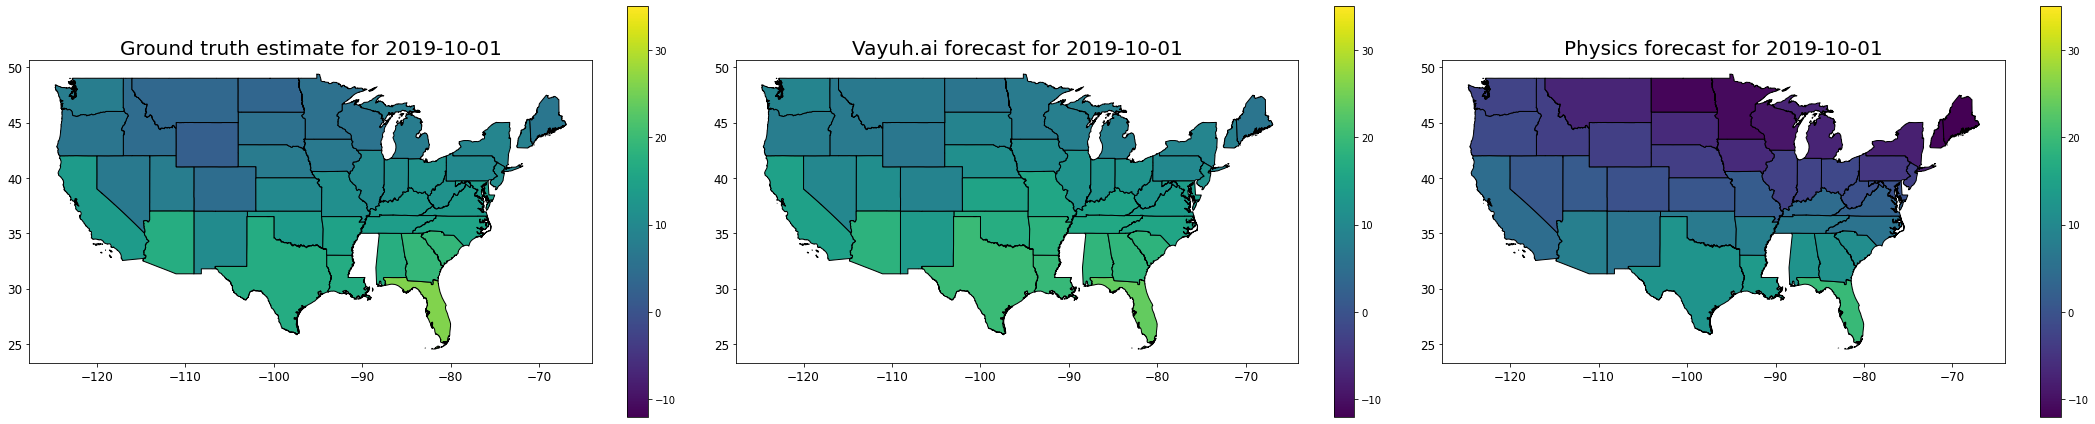

In [45]:
#geoplot choropleths, phys	tmp2m	xgboost_tmp2m_pred
#scheme = mc.EqualInterval(gdf['tmp2m'], k=5)

fig, axes = plt.subplots(figsize=(30,6), ncols=3)
gdf.plot(ax=axes[0], column='tmp2m', cmap='viridis', vmax=35, vmin=-12, linewidth=1, edgecolor='black', legend=True)
axes[0].set_title('Ground truth estimate for 2019-10-01', fontsize=20)
axes[0].tick_params(labelsize=12)
gdf.plot(ax=axes[1], column='xgboost_tmp2m_pred', cmap='viridis', linewidth=1, edgecolor='black', vmax=35, vmin=-12, legend=True)
axes[1].set_title('Vayuh.ai forecast for 2019-10-01', fontsize=20)
axes[1].tick_params(labelsize=12)
gdf.plot(ax=axes[2], column='phys', cmap='viridis', linewidth=1, edgecolor='black', vmax=35, vmin=-12, legend=True)
axes[2].set_title('Physics forecast for 2019-10-01', fontsize=20)
axes[2].tick_params(labelsize=12)
fig.tight_layout()

#gplt.choropleth(gdf, alpha=0.9, hue='tmp2m', projection=gcrs.AlbersEqualArea(),
  # cmap='viridis', edgecolor='black', linewidth=1, legend=True, figsize=(30,6)) 

#plt.title('Title') #ax=ax

#legend_labels = ['< 2.4', '2.4 - 6', '6 - 15', '15 - 38', '38 - 140 M']
    #legend_labels=legend_labels #, legend_kwargs={'loc': 'lower left'}, scheme=scheme
#plt.savefig("r.png", bbox_inches='tight', pad_inches=0.1) #legend_kwargs={'orientation': 'horizontal'}

In [59]:
#Functions
def mbe (x):
    return round(np.mean(x),3)

def mae (x):
    return round(np.mean(abs(x)), 3)

def sd (x):
    return round(np.std(x), 3)

In [47]:
#CHARTDATA 2 - ACROSS THE BOARD
#Get a plottable subset
indexlist = ['State']
vayuhpivot = pd.pivot_table(data=df, index=indexlist, values='err', aggfunc=[mbe,mae,sd])
vayuhpivot.columns = list(map("_".join, vayuhpivot.columns))
vayuhpivot.rename(columns={"mbe_err":"Vayuh MBE", "mae_err":"Vayuh MAE", "sd_err":"Vayuh SD"}, inplace=True)
vayuhpivot
physicspivot = pd.pivot_table(data=df, index=indexlist, values='phys_err', aggfunc=[mbe,mae,sd])
physicspivot.columns = list(map("_".join, physicspivot.columns))
physicspivot.rename(columns={"mbe_phys_err":"Physics MBE", "mae_phys_err":"Physics MAE", "sd_phys_err":"Physics SD"}, inplace=True)
physicspivot
chartdata2 = pd.merge(vayuhpivot, physicspivot, on=indexlist)
chartdata2['Vayuh.ai outperforms'] = chartdata2['Vayuh MAE'] < chartdata2['Physics MAE']
chartdata2

#Get shapefile into geopandas dataframe and merge in forecasts
gdf = gpd.read_file('./us_states/cb_2018_us_state_500k.shp')
gdf = gdf.drop(columns=['ALAND', 'AWATER'])
gdf = gdf.rename(columns={"NAME":"State"})
gdf = gdf.merge(chartdata2, on='State')
gdf

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,State,LSAD,geometry,Vayuh MBE,Vayuh MAE,Vayuh SD,Physics MBE,Physics MAE,Physics SD,Vayuh.ai outperforms
0,37,01027616,0400000US37,37,NC,North Carolina,00,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",1.615,1.615,1.224,-4.590,7.770,8.561,True
1,40,01102857,0400000US40,40,OK,Oklahoma,00,"POLYGON ((-103.00257 36.52659, -103.00219 36.6...",1.812,1.812,1.903,-2.686,7.105,9.653,True
2,51,01779803,0400000US51,51,VA,Virginia,00,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...",1.736,1.736,1.416,-4.754,8.170,9.234,True
3,54,01779805,0400000US54,54,WV,West Virginia,00,"POLYGON ((-82.64320 38.16909, -82.64300 38.169...",1.713,1.713,1.414,-5.200,8.864,9.944,True
4,22,01629543,0400000US22,22,LA,Louisiana,00,"MULTIPOLYGON (((-88.86770 29.86155, -88.86566 ...",1.525,1.525,1.469,-2.701,6.121,7.841,True
5,26,01779789,0400000US26,26,MI,Michigan,00,"MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ...",2.093,2.093,1.661,-4.148,8.629,10.268,True
6,16,01779783,0400000US16,16,ID,Idaho,00,"POLYGON ((-117.24267 44.39655, -117.23484 44.3...",1.931,1.931,1.663,-5.047,8.976,10.496,True
7,12,00294478,0400000US12,12,FL,Florida,00,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ...",1.312,1.312,1.233,-1.843,4.125,4.935,True
8,31,01779792,0400000US31,31,NE,Nebraska,00,"POLYGON ((-104.05342 41.17054, -104.05324 41.1...",2.474,2.474,2.463,-3.892,9.549,11.835,True
9,53,01779804,0400000US53,53,WA,Washington,00,"MULTIPOLYGON (((-122.57039 48.53785, -122.5686...",1.920,1.920,1.817,-5.177,8.746,9.513,True


/home/pranav/anaconda3/envs/newconda/lib/python3.8/site-packages/mapclassify/classifiers.py:1718: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(ms, UserWarning)
/home/pranav/anaconda3/envs/newconda/lib/python3.8/site-packages/mapclassify/classifiers.py:1719: UserWarning: Warning: setting k to 1
  Warn("Warning: setting k to %d" % uvk, UserWarning)
/home/pranav/anaconda3/envs/newconda/lib/python3.8/site-packages/mapclassify/classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam


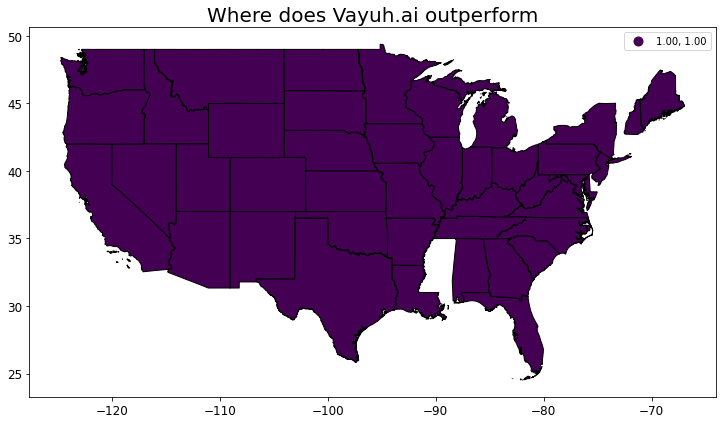

In [48]:
#Geoplots choropleths
#Overall - where outperforms
#scheme = mc.EqualInterval(gdf['Vayuh.ai outperforms'], k=2)
fig, axes = plt.subplots(figsize=(30,6))
gdf.plot(ax=axes, column='Vayuh.ai outperforms', cmap='viridis', linewidth=1, edgecolor='black', scheme='natural_breaks', k=2, vmax=1, vmin=0, legend=True)
axes.set_title('Where does Vayuh.ai outperform', fontsize=20)
axes.tick_params(labelsize=12)
#gplt.choropleth(gdf, alpha=0.9, hue='tmp2m', projection=gcrs.AlbersEqualArea(),
  # cmap='viridis', edgecolor='black', linewidth=1, legend=True, figsize=(30,6)) 
fig.tight_layout()

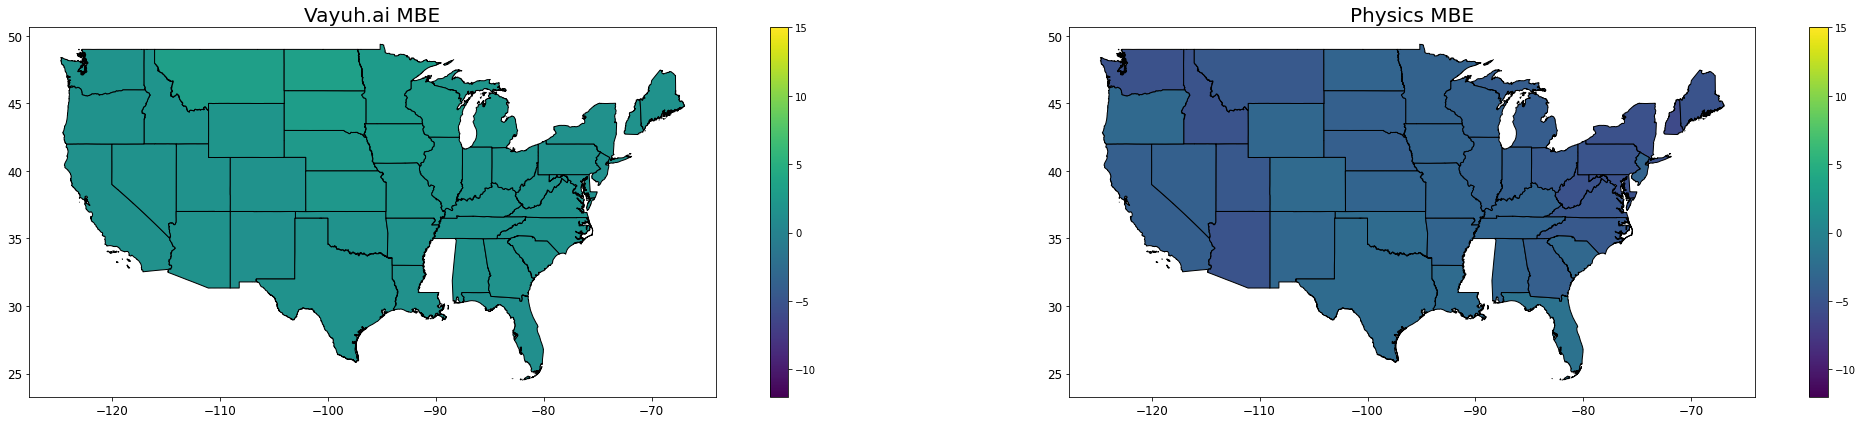

In [49]:
#Vayuh.ai MBE vs Physics MBE
fig, axes = plt.subplots(figsize=(30,6), ncols=2)
gdf.plot(ax=axes[0], column='Vayuh MBE', cmap='viridis', vmax=15, vmin=-12, linewidth=1, edgecolor='black', legend=True)
axes[0].set_title('Vayuh.ai MBE', fontsize=20)
axes[0].tick_params(labelsize=12)
gdf.plot(ax=axes[1], column='Physics MBE', cmap='viridis', vmax=15, vmin=-12, linewidth=1, edgecolor='black', legend=True)
axes[1].set_title('Physics MBE', fontsize=20)
axes[1].tick_params(labelsize=12)
fig.tight_layout()

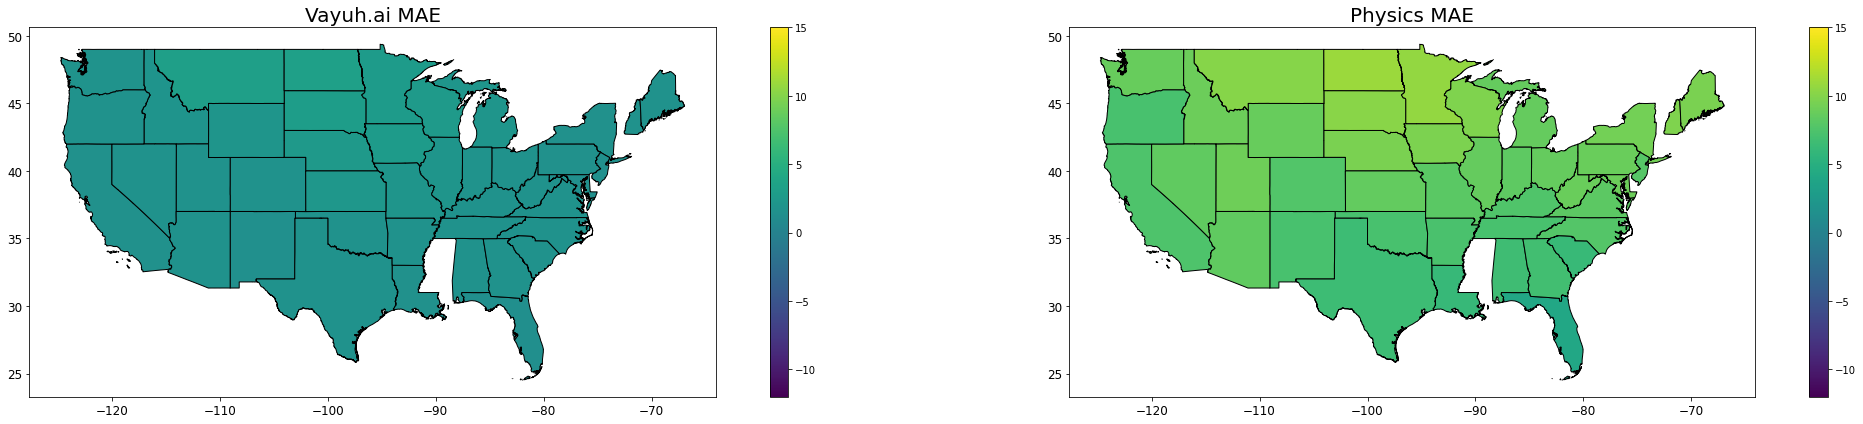

In [50]:
#Vayuh.ai MAE vs Physics MAE
fig, axes = plt.subplots(figsize=(30,6), ncols=2)
gdf.plot(ax=axes[0], column='Vayuh MAE', cmap='viridis', vmax=15, vmin=-12, linewidth=1, edgecolor='black', legend=True)
axes[0].set_title('Vayuh.ai MAE', fontsize=20)
axes[0].tick_params(labelsize=12)
gdf.plot(ax=axes[1], column='Physics MAE', cmap='viridis', vmax=15, vmin=-12, linewidth=1, edgecolor='black', legend=True)
axes[1].set_title('Physics MAE', fontsize=20)
axes[1].tick_params(labelsize=12)
fig.tight_layout()

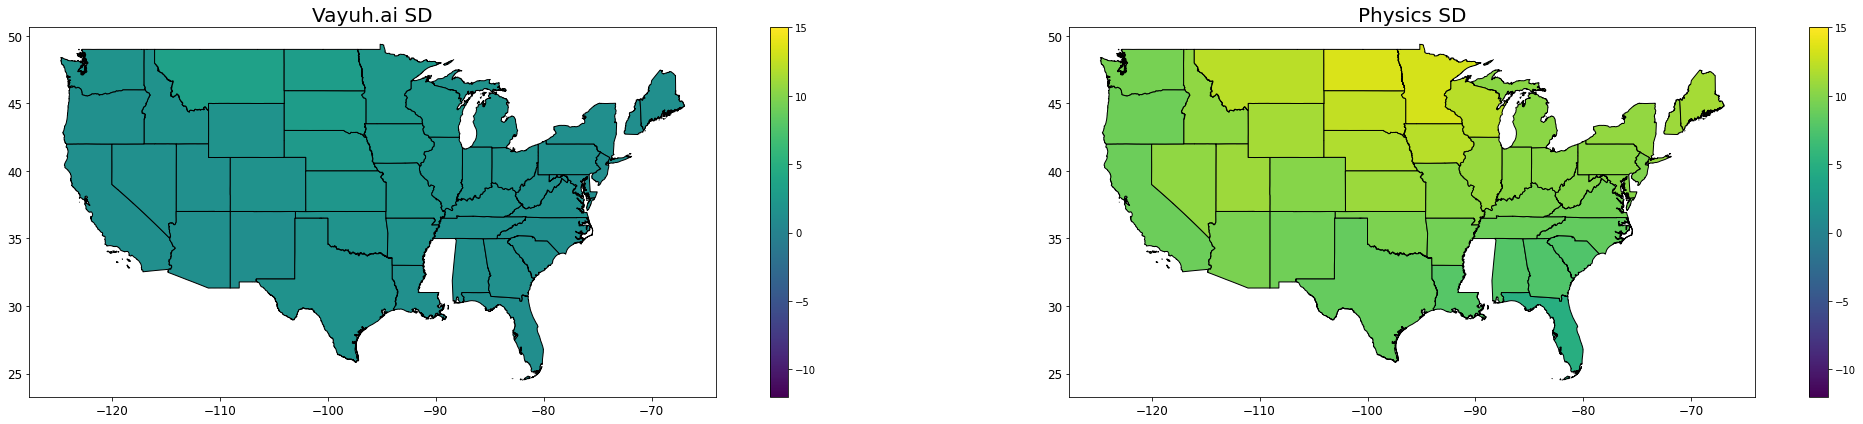

In [51]:
#Vayuh.ai SD vs Physics SD
fig, axes = plt.subplots(figsize=(30,6), ncols=2)
gdf.plot(ax=axes[0], column='Vayuh SD', cmap='viridis', vmax=15, vmin=-12, linewidth=1, edgecolor='black', legend=True)
axes[0].set_title('Vayuh.ai SD', fontsize=20)
axes[0].tick_params(labelsize=12)
gdf.plot(ax=axes[1], column='Physics SD', cmap='viridis', vmax=15, vmin=-12, linewidth=1, edgecolor='black', legend=True)
axes[1].set_title('Physics SD', fontsize=20)
axes[1].tick_params(labelsize=12)
fig.tight_layout()

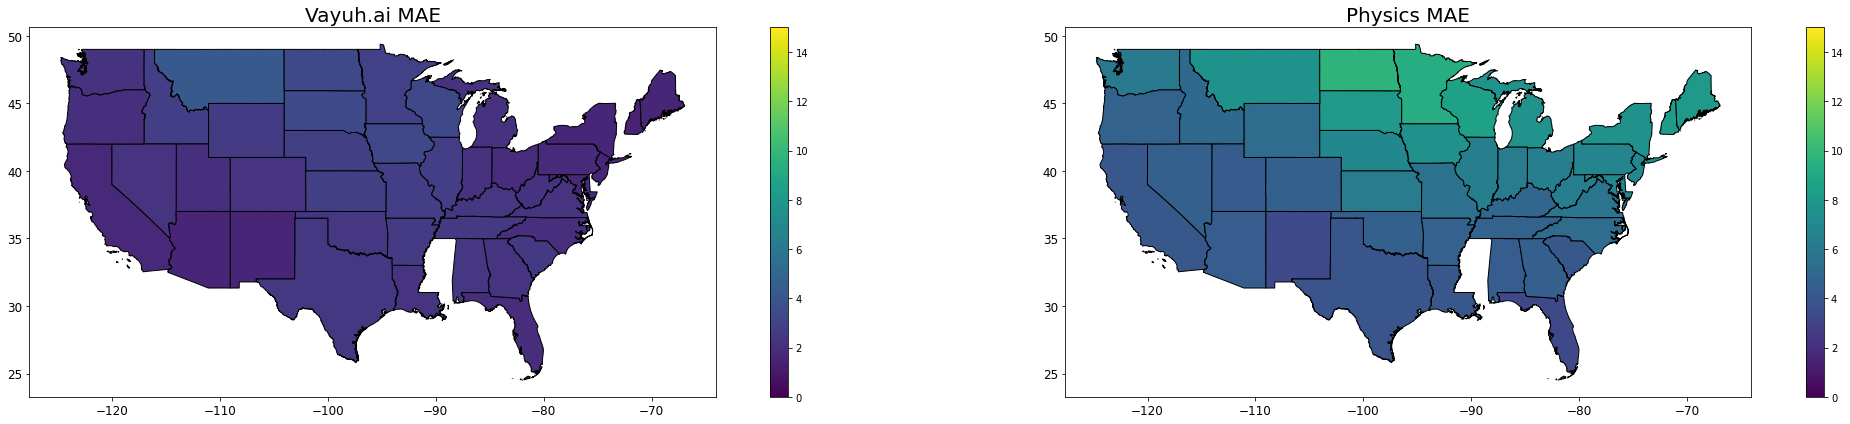

In [21]:
#CHARTDATA 3 - SEASON-WISE
#Get a plottable subset
df_subset = df[df['season']=='fall']
indexlist = ['State']
vayuhpivot = pd.pivot_table(data=df_subset, index=indexlist, values='err', aggfunc=[mbe,mae,sd])
vayuhpivot.columns = list(map("_".join, vayuhpivot.columns))
vayuhpivot.rename(columns={"mbe_err":"Vayuh MBE", "mae_err":"Vayuh MAE", "sd_err":"Vayuh SD"}, inplace=True)
vayuhpivot
physicspivot = pd.pivot_table(data=df_subset, index=indexlist, values='phys_err', aggfunc=[mbe,mae,sd])
physicspivot.columns = list(map("_".join, physicspivot.columns))
physicspivot.rename(columns={"mbe_phys_err":"Physics MBE", "mae_phys_err":"Physics MAE", "sd_phys_err":"Physics SD"}, inplace=True)
physicspivot
chartdata3 = pd.merge(vayuhpivot, physicspivot, on=indexlist)
chartdata3
#Get shapefile into geopandas dataframe and merge in forecasts
gdf = gpd.read_file('./us_states/cb_2018_us_state_500k.shp')
gdf = gdf.drop(columns=['ALAND', 'AWATER'])
gdf = gdf.rename(columns={"NAME":"State"})
gdf = gdf.merge(chartdata3, on='State')
#Plot it
fig, axes = plt.subplots(figsize=(30,6), ncols=2)
gdf.plot(ax=axes[0], column='Vayuh MAE', cmap='viridis', vmax=15, vmin=0, linewidth=1, edgecolor='black', legend=True) 
axes[0].set_title('Vayuh.ai MAE', fontsize=20)
axes[0].tick_params(labelsize=12)
gdf.plot(ax=axes[1], column='Physics MAE', cmap='viridis', vmax=15, vmin=0, linewidth=1, edgecolor='black', legend=True) 
axes[1].set_title('Physics MAE', fontsize=20)
axes[1].tick_params(labelsize=12)
fig.tight_layout()

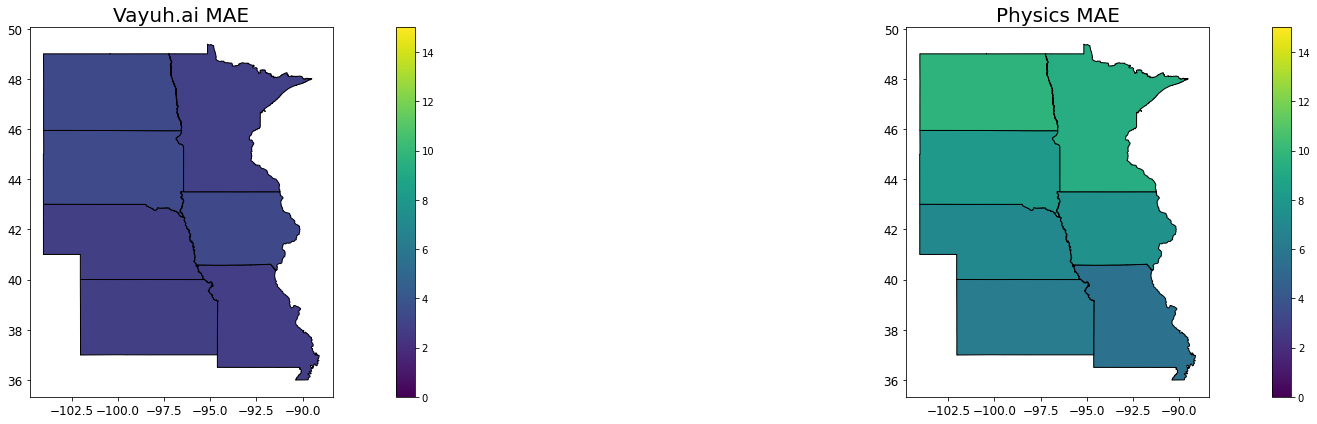

In [31]:
#CHARTDATA 3 - MID-WEST REGION BY SEASON
#Get a plottable subset
df_subset = df[df['season']=='fall']
df_subset = df_subset[df_subset['Sub-Region']=='West North Central']
indexlist = ['State']
vayuhpivot = pd.pivot_table(data=df_subset, index=indexlist, values='err', aggfunc=[mbe,mae,sd])
vayuhpivot.columns = list(map("_".join, vayuhpivot.columns))
vayuhpivot.rename(columns={"mbe_err":"Vayuh MBE", "mae_err":"Vayuh MAE", "sd_err":"Vayuh SD"}, inplace=True)
vayuhpivot
physicspivot = pd.pivot_table(data=df_subset, index=indexlist, values='phys_err', aggfunc=[mbe,mae,sd])
physicspivot.columns = list(map("_".join, physicspivot.columns))
physicspivot.rename(columns={"mbe_phys_err":"Physics MBE", "mae_phys_err":"Physics MAE", "sd_phys_err":"Physics SD"}, inplace=True)
physicspivot
chartdata3 = pd.merge(vayuhpivot, physicspivot, on=indexlist)
chartdata3
#Get shapefile into geopandas dataframe and merge in forecasts
gdf = gpd.read_file('./us_states/cb_2018_us_state_500k.shp')
gdf = gdf.drop(columns=['ALAND', 'AWATER'])
gdf = gdf.rename(columns={"NAME":"State"})
gdf = gdf.merge(chartdata3, on='State')
#Plot it
fig, axes = plt.subplots(figsize=(30,6), ncols=2)
gdf.plot(ax=axes[0], column='Vayuh MAE', cmap='viridis', vmax=15, vmin=0, linewidth=1, edgecolor='black', legend=True)
axes[0].set_title('Vayuh.ai MAE', fontsize=20)
axes[0].tick_params(labelsize=12)
gdf.plot(ax=axes[1], column='Physics MAE', cmap='viridis', vmax=15, vmin=0, linewidth=1, edgecolor='black', legend=True)
axes[1].set_title('Physics MAE', fontsize=20)
axes[1].tick_params(labelsize=12)
fig.tight_layout()

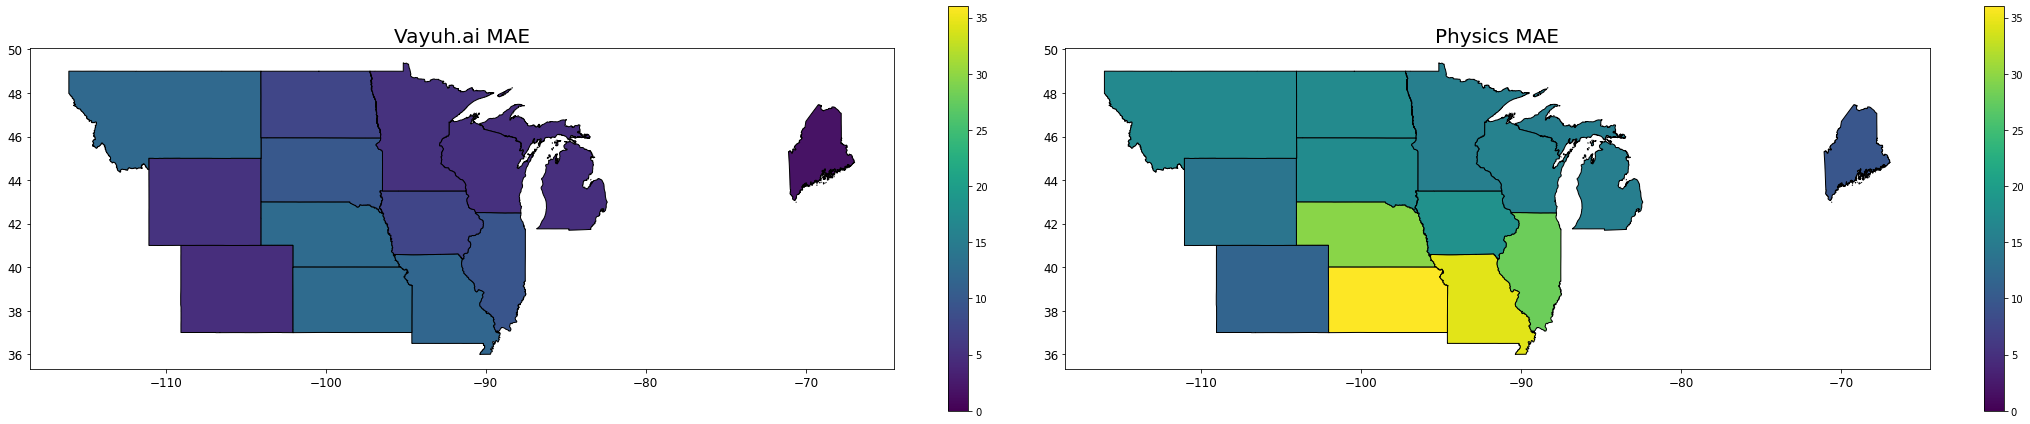

In [60]:
#CHARTDATA 4 - GENERAL HEATWAVE or COLDWAVE
#Get a plottable subset
df_subset = df[df['coldwave']==True]
indexlist = ['State']
vayuhpivot = pd.pivot_table(data=df_subset, index=indexlist, values='err', aggfunc=[mbe,mae,sd])
vayuhpivot.columns = list(map("_".join, vayuhpivot.columns))
vayuhpivot.rename(columns={"mbe_err":"Vayuh MBE", "mae_err":"Vayuh MAE", "sd_err":"Vayuh SD"}, inplace=True)
vayuhpivot
physicspivot = pd.pivot_table(data=df_subset, index=indexlist, values='phys_err', aggfunc=[mbe,mae,sd])
physicspivot.columns = list(map("_".join, physicspivot.columns))
physicspivot.rename(columns={"mbe_phys_err":"Physics MBE", "mae_phys_err":"Physics MAE", "sd_phys_err":"Physics SD"}, inplace=True)
physicspivot
chartdata3 = pd.merge(vayuhpivot, physicspivot, on=indexlist)
chartdata3
#Get shapefile into geopandas dataframe and merge in forecasts
gdf = gpd.read_file('./us_states/cb_2018_us_state_500k.shp')
gdf = gdf.drop(columns=['ALAND', 'AWATER'])
gdf = gdf.rename(columns={"NAME":"State"})
gdf = gdf.merge(chartdata3, on='State')
#Plot it
fig, axes = plt.subplots(figsize=(30,6), ncols=2)
gdf.plot(ax=axes[0], column='Vayuh MAE', cmap='viridis', vmax=36, vmin=0, linewidth=1, edgecolor='black', legend=True) 
axes[0].set_title('Vayuh.ai MAE', fontsize=20)
axes[0].tick_params(labelsize=12)
gdf.plot(ax=axes[1], column='Physics MAE', cmap='viridis', vmax=36, vmin=0, linewidth=1, edgecolor='black', legend=True)
axes[1].set_title('Physics MAE', fontsize=20)
axes[1].tick_params(labelsize=12)
fig.tight_layout()

In [ ]:
#CHARTDATA 5 - COMPARISON AGAINST SALIENT.AI
#Get a plottable subset
sd = '2020-10-13'
df_subset = df[df['start_date']==sd]
df_subset
indexlist = ['State']
vayuhpivot = pd.pivot_table(data=df_subset, index=indexlist, values='err', aggfunc=[mbe,mae,sd])
vayuhpivot.columns = list(map("_".join, vayuhpivot.columns))
vayuhpivot.rename(columns={"mbe_err":"Vayuh MBE", "mae_err":"Vayuh MAE", "sd_err":"Vayuh SD"}, inplace=True)
vayuhpivot
physicspivot = pd.pivot_table(data=df_subset, index=indexlist, values='phys_err', aggfunc=[mbe,mae,sd])
physicspivot.columns = list(map("_".join, physicspivot.columns))
physicspivot.rename(columns={"mbe_phys_err":"Physics MBE", "mae_phys_err":"Physics MAE", "sd_phys_err":"Physics SD"}, inplace=True)
physicspivot
chartdata5 = pd.merge(vayuhpivot, physicspivot, on=indexlist)
chartdata5
#Get shapefile into geopandas dataframe and merge in forecasts
gdf = gpd.read_file('./us_states/cb_2018_us_state_500k.shp')
gdf = gdf.drop(columns=['ALAND', 'AWATER'])
gdf = gdf.rename(columns={"NAME":"State"})
gdf = gdf.merge(chartdata5, on='State')
#Plot it
fig, axes = plt.subplots(figsize=(30,6), ncols=2)
gdf.plot(ax=axes[0], column='Vayuh MAE', cmap='viridis', vmax=35, vmin=-12, legend=True) #vmax=10, vmin=0
axes[0].set_title('Vayuh.ai MAE', fontsize=20)
axes[0].tick_params(labelsize=12)
gdf.plot(ax=axes[1], column='Physics MAE', cmap='viridis', vmax=10, vmin=0, legend=True) 
axes[1].set_title('Physics MAE', fontsize=20)
axes[1].tick_params(labelsize=12)
fig.tight_layout()

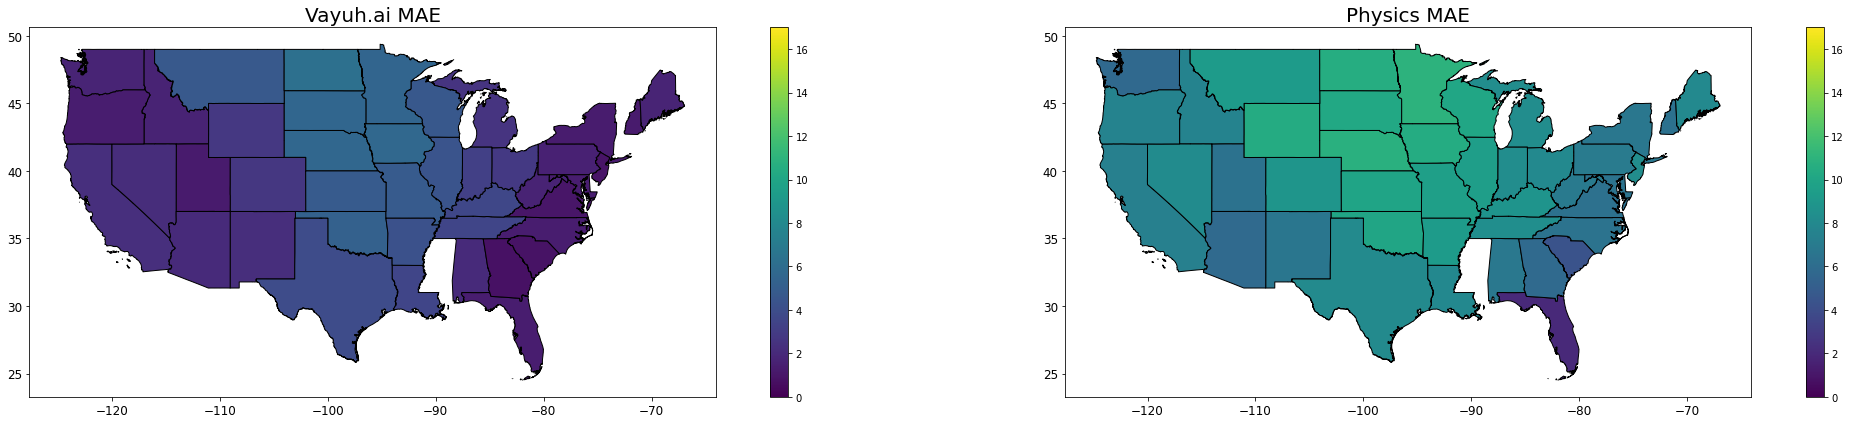

In [62]:
#CHARTDATA 6 - TEXAS COLD / OREGON HEAT
#Get a plottable subset
texascoldwave = df[(df['start_date']>='2021-01-23') & (df['start_date']<='2021-02-28')]
oregonheatwave = df[(df['start_date']>='2021-06-14') & (df['start_date']<='2021-07-01')]
df_subset = texascoldwave
indexlist = ['State']
vayuhpivot = pd.pivot_table(data=df_subset, index=indexlist, values='err', aggfunc=[mbe,mae,sd])
vayuhpivot.columns = list(map("_".join, vayuhpivot.columns))
vayuhpivot.rename(columns={"mbe_err":"Vayuh MBE", "mae_err":"Vayuh MAE", "sd_err":"Vayuh SD"}, inplace=True)
vayuhpivot
physicspivot = pd.pivot_table(data=df_subset, index=indexlist, values='phys_err', aggfunc=[mbe,mae,sd])
physicspivot.columns = list(map("_".join, physicspivot.columns))
physicspivot.rename(columns={"mbe_phys_err":"Physics MBE", "mae_phys_err":"Physics MAE", "sd_phys_err":"Physics SD"}, inplace=True)
physicspivot
chartdata5 = pd.merge(vayuhpivot, physicspivot, on=indexlist)
chartdata5
#Get shapefile into geopandas dataframe and merge in forecasts
gdf = gpd.read_file('./us_states/cb_2018_us_state_500k.shp')
gdf = gdf.drop(columns=['ALAND', 'AWATER'])
gdf = gdf.rename(columns={"NAME":"State"})
gdf = gdf.merge(chartdata5, on='State')
#Plot it
fig, axes = plt.subplots(figsize=(30,6), ncols=2)
gdf.plot(ax=axes[0], column='Vayuh MAE', cmap='viridis', vmax=17, vmin=0, linewidth=1, edgecolor='black', legend=True) #vmax=10, vmin=0
axes[0].set_title('Vayuh.ai MAE', fontsize=20)
axes[0].tick_params(labelsize=12)
gdf.plot(ax=axes[1], column='Physics MAE', cmap='viridis', vmax=17, vmin=0, linewidth=1, edgecolor='black', legend=True) 
axes[1].set_title('Physics MAE', fontsize=20)
axes[1].tick_params(labelsize=12)
fig.tight_layout()

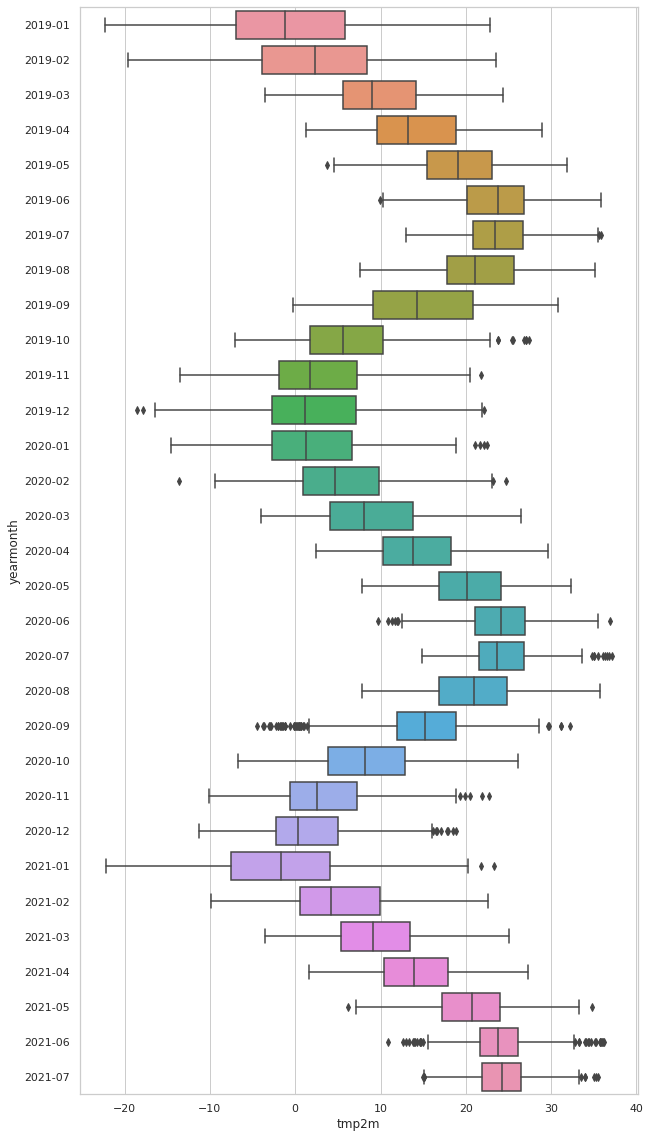

In [49]:
#Temp boxplot by month
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,20))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="tmp2m", y="yearmonth", data=df.sort_values(by='yearmonth'))
plt.savefig('temp_boxplot_yearmonth.png')

In [50]:
#Average annual temp 2019, 2020, 2021
indexlist = ['year']
pivot = pd.pivot_table(data=df, index=indexlist, values='tmp2m', aggfunc=[np.average, np.min, np.max])
pivot

,average,amin,amax
,tmp2m,tmp2m,tmp2m
year,,,
2019,11.294570,-22.309698,35.850639
2020,12.359184,-14.544649,37.168133
2021,13.530494,-22.177216,36.239494


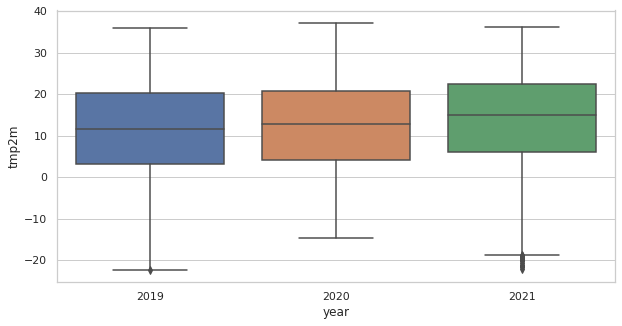

In [52]:
#Temp boxplots by year
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="year", y="tmp2m", data=df)
plt.savefig('temp_boxplot_year.png')

In [72]:
#temp difference between LaNina and ElNino years
pivot = pd.pivot_table(data=df, index='month2', columns='year', values='tmp2m', aggfunc=[np.average])
pivot.columns = [f'{j}_{i}' for i, j in pivot.columns]
#pivot.columns = pivot.columns.map('_'.join)
#pivot.rename(columns={"mbe_phys_err":"Physics MBE", "mae_phys_err":"Physics MAE", "sd_phys_err":"Physics SD"}, inplace=True)
pivot['avgdifference (2021-2019)'] = pivot['2021_average'] - pivot['2019_average']
pivot['2019_average'] = round(pivot['2019_average'],3)
pivot['2020_average'] = round(pivot['2020_average'],3)
pivot['2021_average'] = round(pivot['2021_average'],3)
pivot['avgdifference (2021-2019)'] = round(pivot['avgdifference (2021-2019)'],3)
pivot

,2019_average,2020_average,2021_average,avgdifference (2021-2019)
month2,,,,
01,-0.919,1.913,-1.712,-0.792
02,1.962,5.476,5.043,3.081
03,9.679,9.115,9.670,-0.009
04,14.132,14.578,14.314,0.182
05,19.194,20.198,20.473,1.279
06,23.198,23.781,23.800,0.602
07,23.728,24.076,24.188,0.460
08,21.561,20.930,NaN,NaN
09,15.079,15.035,NaN,NaN
